In [19]:
import torch
import torchtext
from torchtext.datasets import text_classification
import os
import pandas as pd
import seaborn as sns
import numpy as np

import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from joblib import dump, load
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

In [67]:
#File path to the csv file
csv_file = "./.data/ag_news_csv/train.csv"

# Read csv file into dataframe
df = pd.read_csv(csv_file, names=["label", "title", "text"])

# Print first 5 rows in the dataframe
df.head()

,label,title,text
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [4]:
df['label'].value_counts()

4    30000
3    30000
2    30000
1    30000
Name: label, dtype: int64

In [5]:
label_file = "./.data/ag_news_csv/classes.txt"

In [7]:
with open(label_file) as f:
    file_contents = f.read()
    print(file_contents)

World
Sports
Business
Sci/Tech



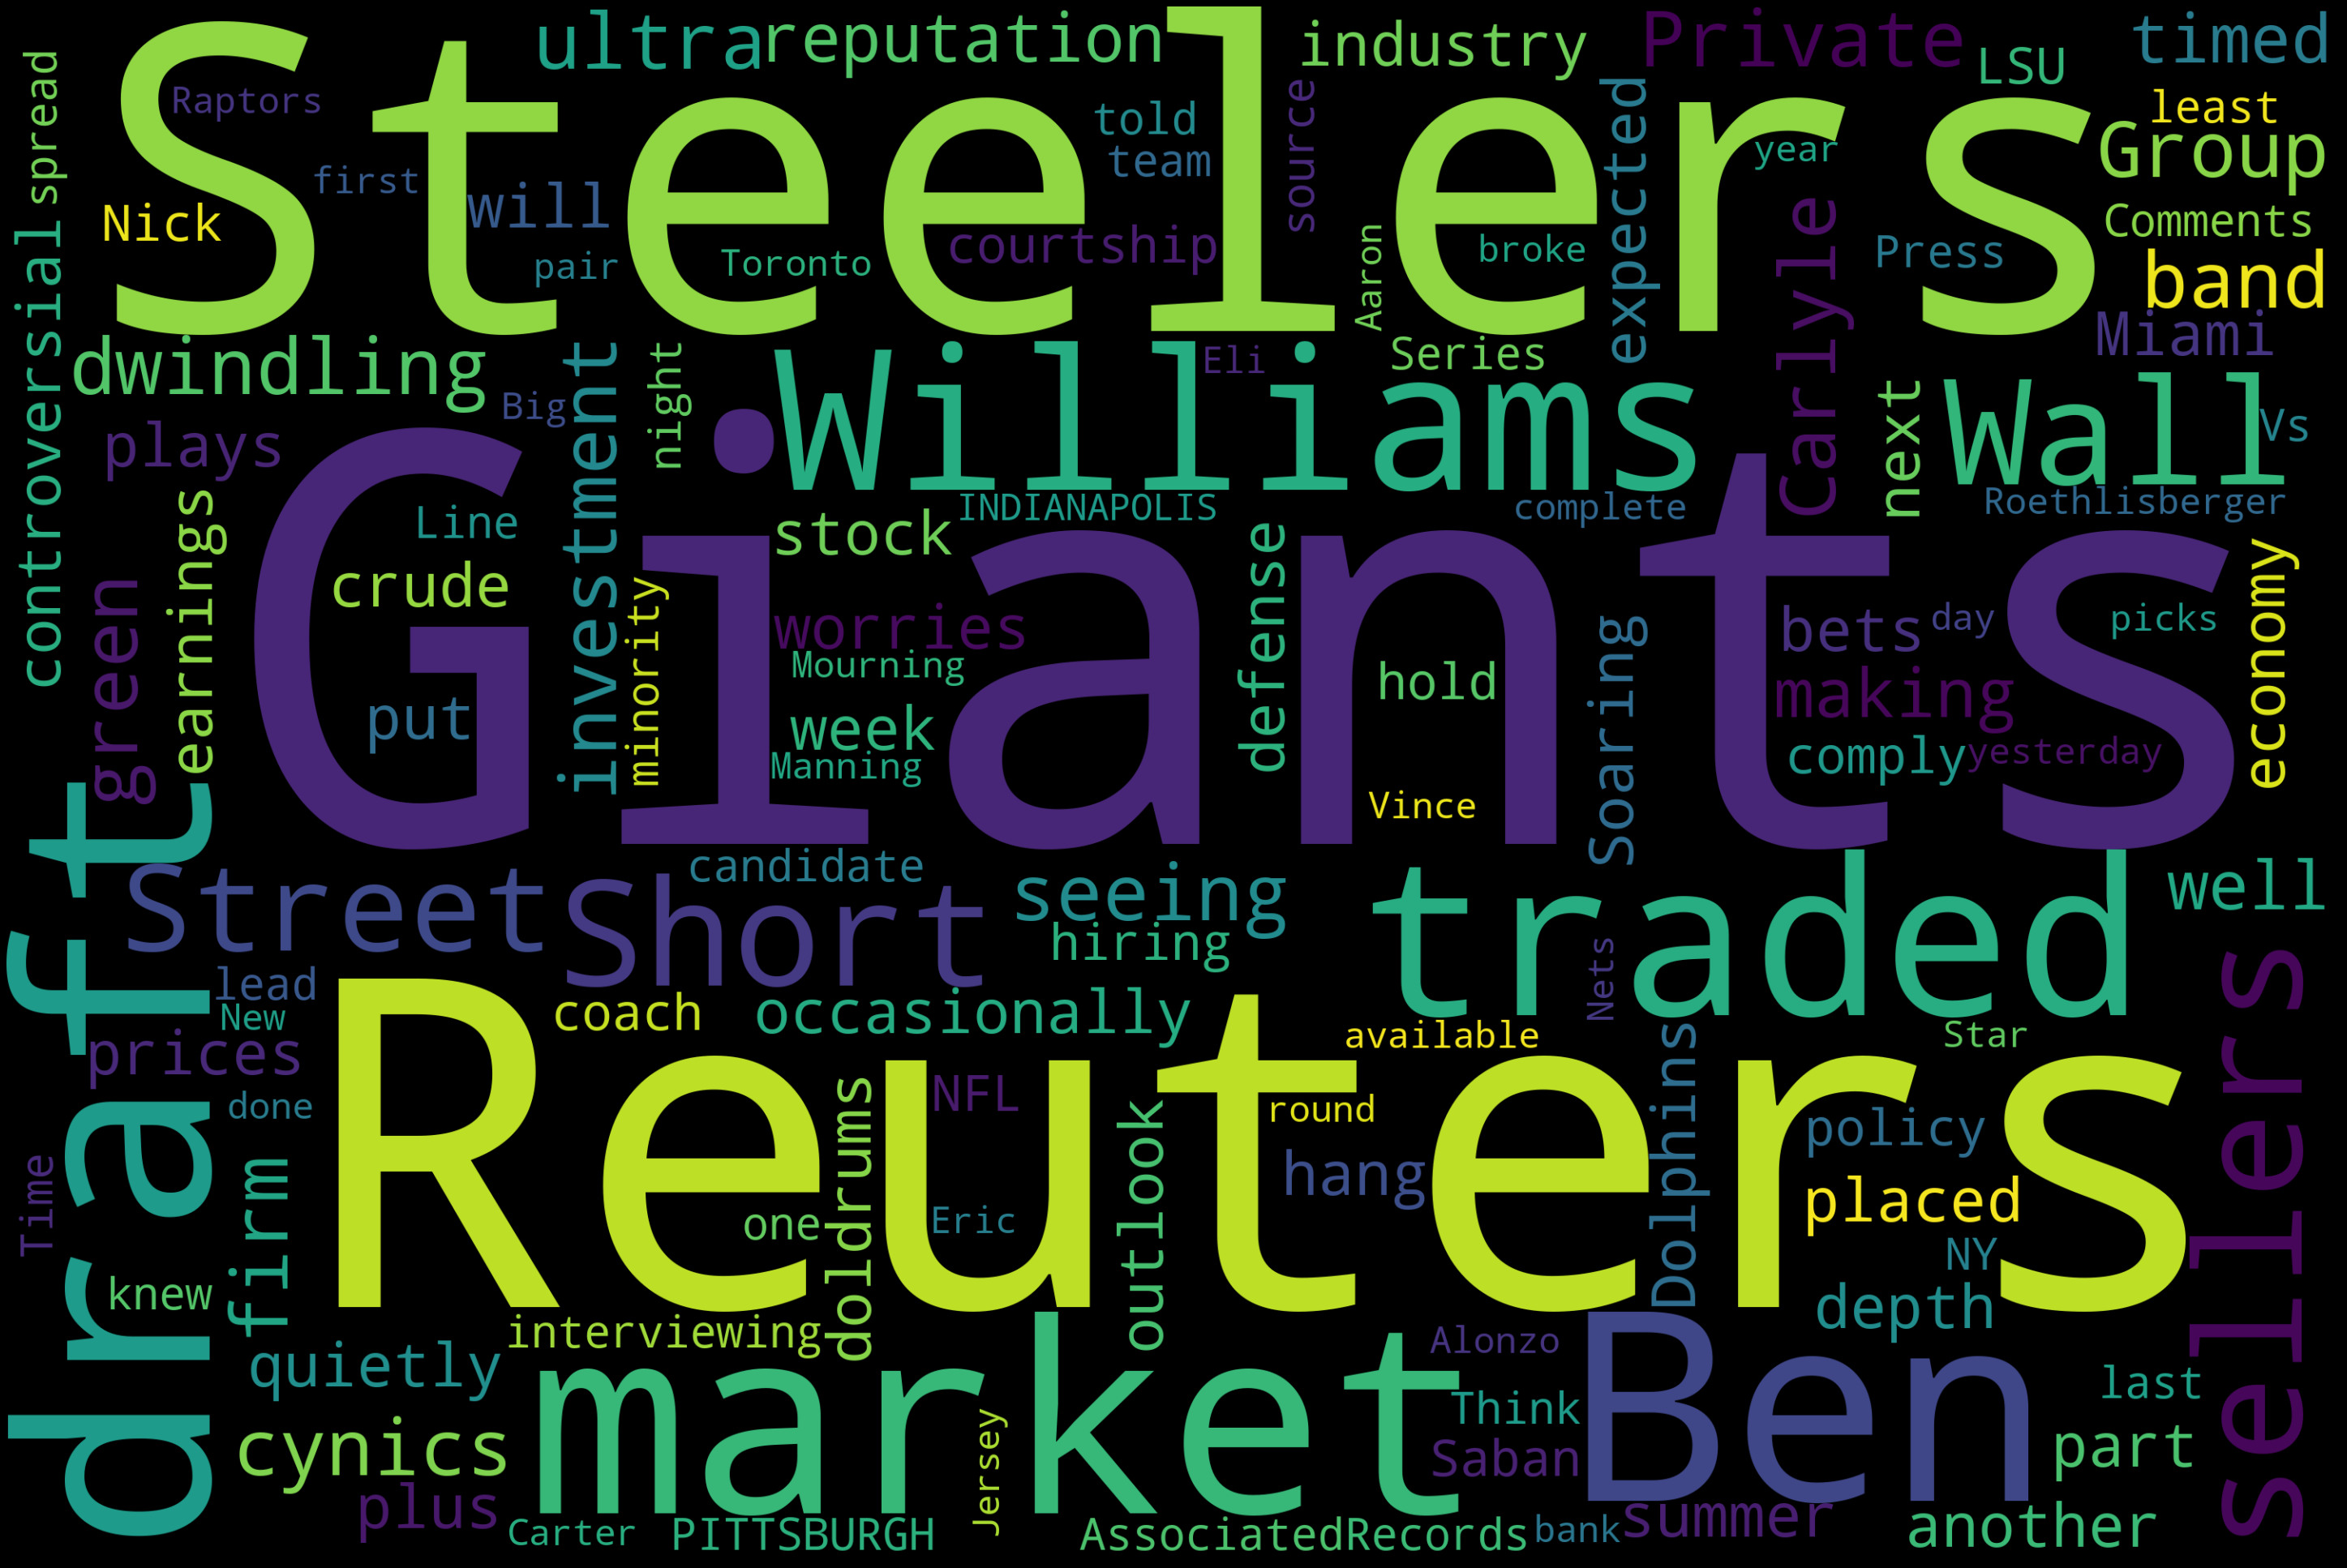

In [9]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
text = df.text.values
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## Split Data to Test and Train

In [10]:
X,y = df.text, df.label

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

## Visualize how text turns into numbers ([word embedding](https://en.wikipedia.org/wiki/Word_embedding))

In [139]:
def get_vector_feature_matrix():
    vectorizer = CountVectorizer(lowercase=True, stop_words="english", max_features=5,ngram_range=(1, 2), max_df=0.6)
    #vectorizer = CountVectorizer(lowercase=True, stop_words="english", max_features=4000)
    #vectorizer = CountVectorizer(lowercase=True, stop_words="english",ngram_range=(1, 2), max_features=5000)
    #vectorizer = CountVectorizer(lowercase=True, stop_words="english", tokenizer=stemming_tokenizer) 
    vector = vectorizer.fit_transform(np.array(df.text))
    return vector, vectorizer

In [140]:
vector, vectorizer = get_vector_feature_matrix()

In [141]:
print(vectorizer.get_feature_names())

['39', 'new', 'quot', 'reuters', 'said']


In [142]:
print(vector.toarray()[500])

[0 0 0 0 1]


In [143]:
df['text'].iloc[500]

"AP - Democratic presidential candidate John Kerry does not plan to visit Florida in the aftermath of Hurricane Charley because he's concerned his campaign entourage could distract from recovery efforts, he said Saturday."

In [144]:
print(vectorizer.vocabulary_)

{'reuters': 3, 'said': 4, 'new': 1, 'quot': 2, '39': 0}


In [145]:
x = vectorizer.transform(np.array([df['text'].iloc[500]]))
print(x)

  (0, 4)	1


In [146]:
print(len(vectorizer.vocabulary_))

5


## Create and Test Model

In [147]:
pipeline = Pipeline([
    ('vect', CountVectorizer(stop_words="english",ngram_range=(1, 2), max_features=100000)),
    ('clf', LogisticRegression(multi_class='ovr',max_iter=500)),
])

pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=100000, min_df=1,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('clf',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=500,
                                    multi_class='ovr', n_jobs=None,
                    

In [148]:
accuracy = pipeline.score(X_test, y_test)
print ("Accuracy is {}".format(accuracy))

Accuracy is 0.91425


In [149]:
x_text = ["MEMPHIS, Tenn. – Four days ago, Jon Rahm was \
    enduring the season’s worst weather conditions on Sunday at The \
    Open on his way to a closing 75 at Royal Portrush, which \
    considering the wind and the rain was a respectable showing. \
    Thursday’s first round at the WGC-FedEx St. Jude Invitational \
    was another story. With temperatures in the mid-80s and hardly any \
    wind, the Spaniard was 13 strokes better in a flawless round. \
    Thanks to his best putting performance on the PGA Tour, Rahm \
    finished with an 8-under 62 for a three-stroke lead, which \
    was even more impressive considering he’d never played the \
    front nine at TPC Southwind."]

In [150]:
x = np.array(x_text)
proba = pipeline.predict_proba(x_text)
classes = pipeline.classes_
resultdf = pd.DataFrame(data=proba, columns=classes)

In [151]:
result =pipeline.predict(x)[0]

ag_news_label = {1 : "World",
                 2 : "Sports",
                 3 : "Business",
                 4 : "Sci/Tec"}

print(f"Predicted: {result}")
print("This is a %s news article" %ag_news_label[result])

Predicted: 2
This is a Sports news article


In [152]:
resultdf

,1,2,3,4
0,0.000326,0.999635,4.818094e-07,0.000038
